### Use of LLM(ChatGPT-4o) to generate fake CFD data and add some noise

In [166]:
# import libs 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [167]:
# Read the synthetic data
path ="/mnt/d/CFD-stuff/Approaching-ML-Problems-in-CFD-and-CAE-Apps/ml-project1/Input"
df_cylinders = pd.read_csv(path + "/fake-cfd-cylinder-flow-ChatGPT-4o.csv")
df_cylinders.head()

,velocity,Reynolds_number,pressure,flow_type
0,0.00,0.0,101325.0,laminar
1,2.53,5050.5,101072.5,laminar
2,5.05,10101.0,100819.9,laminar
3,7.58,15151.5,100567.4,laminar
4,10.10,20202.0,100314.9,laminar


### Perform some data augmentation by adding some noise to the data

In [168]:
def add_noise_to_velocity(df, noise_level=0.1):
    """
    Add Gaussian noise to the velocity data in the DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame containing velocity data.
    noise_level (float): The standard deviation of the Gaussian noise to be added.
    
    Returns:
    DataFrame: A new DataFrame with added noise to the velocity data.
    """
    
    # Add Gaussian noise to the velocity columns
    noise = np.random.normal(0, noise_level, size=df['velocity'].shape)
    df['velocity'] = df['velocity'] + noise
    return df
# Add noise to the velocity colun
data_noisy = add_noise_to_velocity(df_cylinders.copy(), noise_level=5) #Adjust noise level as needed
    

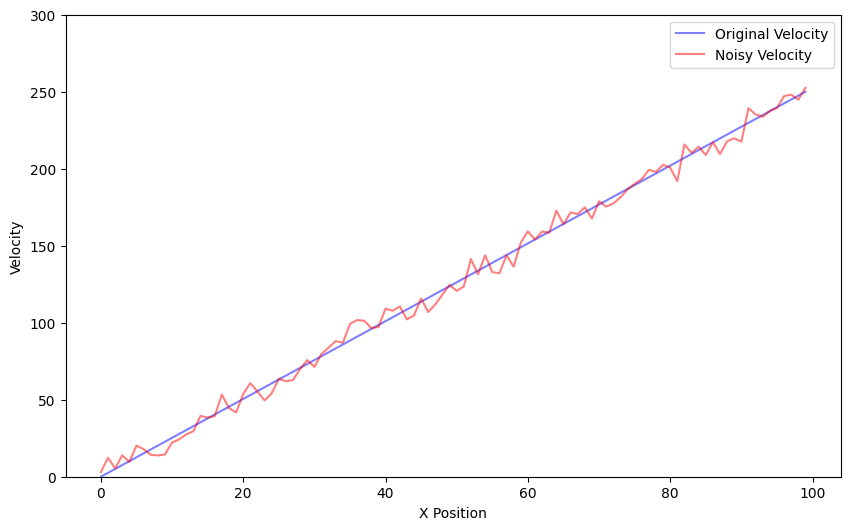

In [169]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the original and noisy velocity data
ax.plot(np.arange(0, len(df_cylinders['velocity'])), df_cylinders['velocity'], label='Original Velocity', color='blue', alpha=0.5)
ax.plot(np.arange(0, len(df_cylinders['velocity'])), data_noisy['velocity'], label='Noisy Velocity', color='red', alpha=0.5)
ax.set_xlabel('X Position')
ax.set_ylabel('Velocity')
ax.set_ylim(0,300)
ax.legend()

In [170]:
# Function to perform boostrap sampling - The bootstrap_sample fucntiion is used to create a new dataset by 
# sampling with replacement from the original dataset
# this helps when we are after estimating the distribution of a statistic .i.e standard deviation and for model validation
y =  df_cylinders['velocity']
X_features = df_cylinders.drop('velocity',axis=1)

def bootstrap_sample(X, y):
    print(X.shape,y.shape)
    indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
    return X.iloc[indices], y.iloc[indices]

# Create a bootstrap sample
X_bootstrap, y_bootstrap = bootstrap_sample(X_features, y)

(100, 3) (100,)


In [171]:
X_features.head(), y.head()

(   Reynolds_number  pressure flow_type
 0              0.0  101325.0   laminar
 1           5050.5  101072.5   laminar
 2          10101.0  100819.9   laminar
 3          15151.5  100567.4   laminar
 4          20202.0  100314.9   laminar,
 0     0.00
 1     2.53
 2     5.05
 3     7.58
 4    10.10
 Name: velocity, dtype: float64)

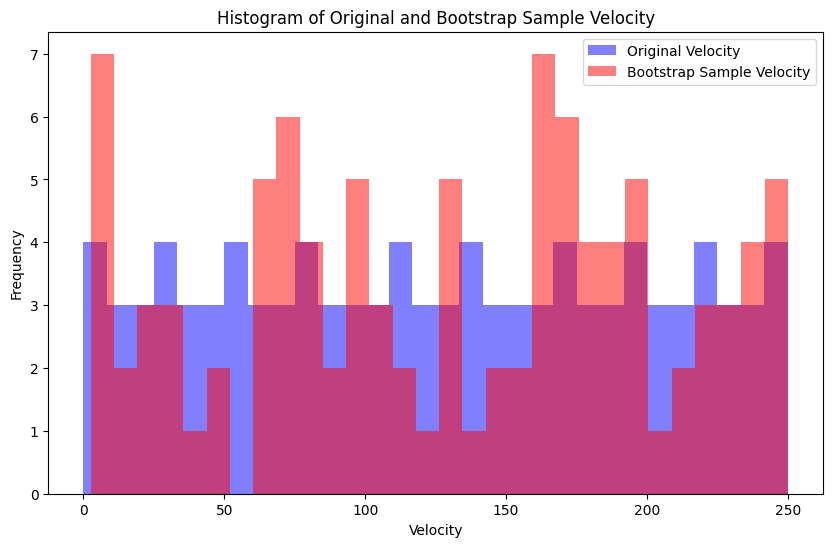

In [172]:
# Plot a histogram of the bootstrap sample against the original data
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, alpha=0.5, label='Original Velocity', color='blue')
plt.hist(y_bootstrap, bins=30, alpha=0.5, label='Bootstrap Sample Velocity', color='red')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Original and Bootstrap Sample Velocity')
plt.legend()

### Using cross-validation in a small dataset 
Cross-validation splits the data into differnt training and validations sets, named folds (or into `k` number of folds)
so that every sample can be used for validation exactly ones.

### Perform a 3-fold cross-validation on the dataset with a random forest model
`cv=3` argument in the cross_val_score function specifies that a 3-fold cross validation should be used, i.e. the data
into 3 equal parts or "folds" (2 folds used for training, and the remaining fold will be used for validation). The process is repeated 3 times, but is not uncommon to repeat it more times in larger datasets.

one variable is the flow regime which is not numerical so there is the need to employ a one-hot encoding i.e. turbulent sampes is `0` and laminar as `1`

In [173]:
# One-hot encode he "flow_type" column
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(X_features[['flow_type']])
X_features_encoded = pd.concat([X_features.drop(columns=['flow_type']),
        pd.DataFrame(
            encoded_features,
            columns=encoder.get_feature_names_out(['flow_type']),
            index=X_features.index
        )
    ],
    axis=1
)

In [184]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
X_features_encoded, y = make_regression(n_features=4, n_informative=2,
                       random_state=42, shuffle=False)
# Create and train the model
model = RandomForestRegressor()
model.fit(X_features_encoded, y)
scores = cross_val_score(model, X_features_encoded, y, cv =3, scoring ='neg_mean_squared_error')
print("Negative Mean Squared Error for each fold:",scores)
print("Negative Mean Squared Error:",scores.mean())
print("Standard deviation of Negative Mean Squared Error:",scores.std())


Negative Mean Squared Error for each fold: [-263.67561588 -412.80577531  -47.7742739 ]
Negative Mean Squared Error: -241.4185550299918
Standard deviation of Negative Mean Squared Error: 149.85222014360136


#### How to avoid biases, and to steer the model away from achieiving 95% accuracy of predicting laminar cases which dominate the samples

In [185]:
df_cylinders['flow_type'].value_counts()

flow_type
laminar      90
turbulent    10
Name: count, dtype: int64

In [186]:
#!conda install -c conda-forge  imbalanced-learn -y

In [187]:
### we can down-sample the majority class to balance the cless distribution in the dataset
# by reducing the number of examples in the majority class
# Create a random under-sampler
from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
X_features_encoded, y = make_classification(n_classes=2, class_sep=2,weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=100, n_clusters_per_class=1, n_samples=100, random_state=10)
rus = RandomUnderSampler(random_state=42)

# Apply the random under-sampler
X_downsampled, y_downsampled = rus.fit_resample(X_features_encoded, y)
print('Before resampling dataset shape %s' % Counter(y))
print('After resampleing dataset shape %s' % Counter(y_downsampled))

Before resampling dataset shape Counter({np.int64(1): 90, np.int64(0): 10})
After resampleing dataset shape Counter({np.int64(0): 10, np.int64(1): 10})


### Other approaches are available when there is class imbalance scenarios:
- Synthetic Minority Over-Sampling Technique (SMOTE and regression version SMOTER), creating synthetic samples to reduce overfitting

##### - Regularization techniques such as L1 or L2 which is useful for small datasets, which adds a penalty term to tthe loss function of the model

##### Always note when splitting into training data, test data and validation data, dividing by % i.e. 70/20/10
- Training refers to the model learning from input data and adjusting its internal parameters during training to minimize the error
- Optimization process involves techniques like gradient descent to fit the data-different than convergence.
- The process of setting the internal parameters (weights, biases) is the process of training over iterations (epochs). At every epoch, the training data is used to propose (forward pass) what the coefficients should be and at the end  of the training the validation data is used to evaluate the error.--> when it reaches acceptable low levels of error, the models setup/parameters has been determined.
-When it's completed, the `testing data`,separate data, is used for 'blind' testing of the model performance.
- Hyperparemeter tuning sweeps happen priori the evaluation of the testing dataset

### Random forest classifier model
#### Reference:
 https://www.datacamp.com/tutorial/random-forests-classifier-python

In [221]:
import numpy as np

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image


In [222]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'flow_type' labels to 0 and 1
le = LabelEncoder()
y = le.fit_transform(df_cylinders['flow_type'])
X_features = df_cylinders.drop('flow_type',axis=1)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test =train_test_split(X_features, y, test_size=0.33, random_state=42)
# Modelling
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [223]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8484848484848485


In [224]:
#!pip install graphviz

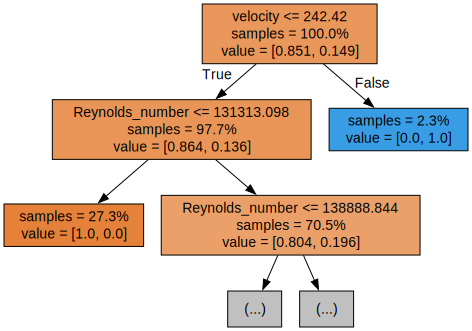

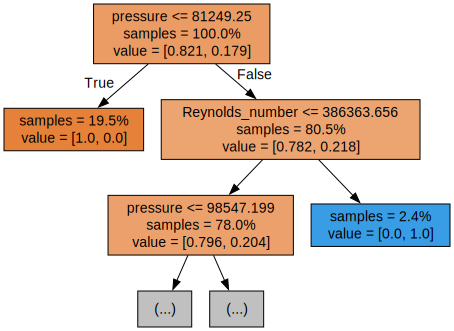

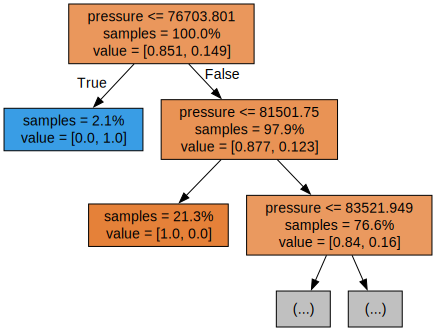

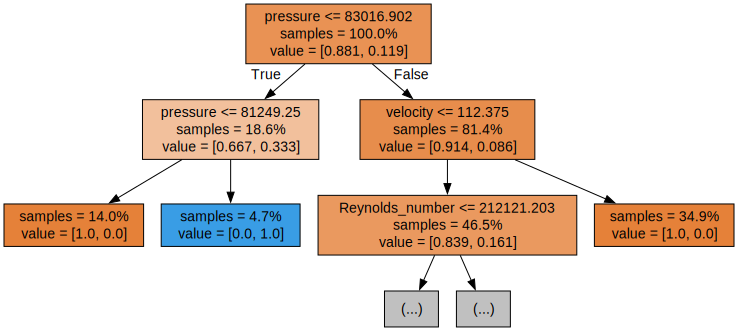

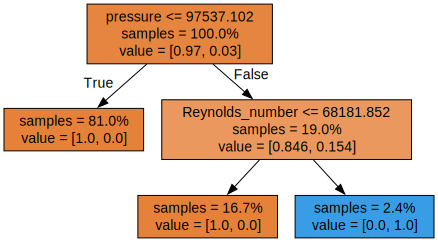

In [225]:
import graphviz
# Export the first five decision trees from the forest

#print(X_train)
for i in range(5):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree, 
                               feature_names=X_features.columns,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

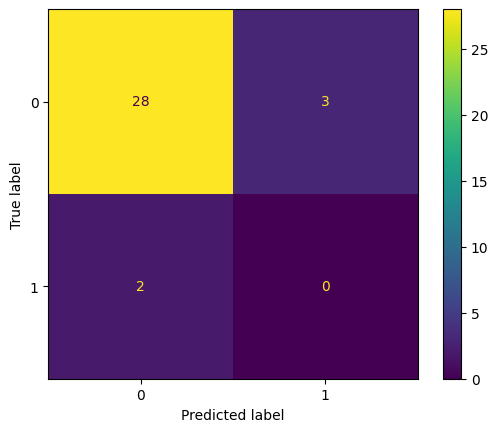

In [226]:
# Confusion matrix to evaluate the model
# Shows what the model predicted vs what it should have predicted

# Generate predictions with the best model
y_pred = rf_model.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [227]:
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8484848484848485
Precision: 0.0
Recall: 0.0


### Hyperparameter Tuning
n_estimators: the number of decision trees in the forest. Increasing this hyperparameter generally improves the performance of the model but also increases the computational cost of training and predicting

max_depth: the maximum depth of each decision tree in the forest. Setting a higher value for max_depth can lead to overfitting while setting it too low can lead to underfitting.



In [215]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x770d34831f10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x770d34833c20>})

In [216]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 6, 'n_estimators': 93}


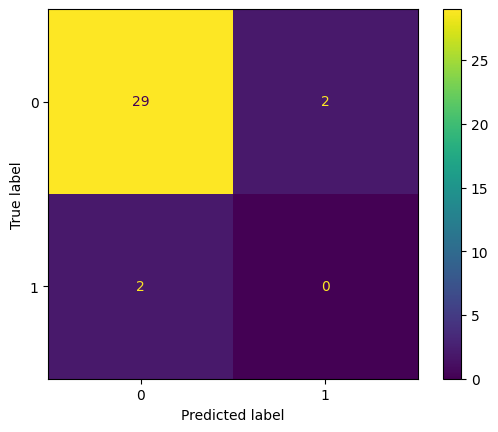

In [217]:
# Confusion matrix to evaluate the model
# Shows what the model predicted vs what it should have predicted

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [218]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8787878787878788
Precision: 0.0
Recall: 0.0


<Axes: >

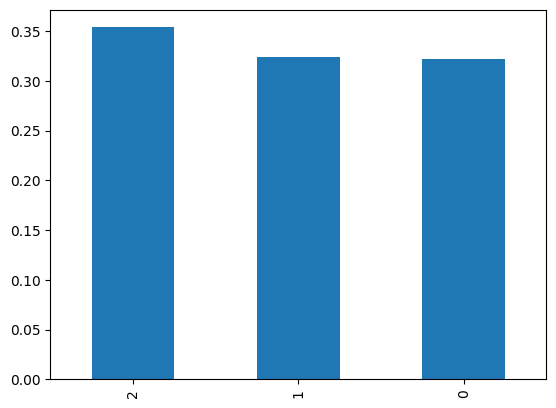

In [219]:
# Plot the feature importance, using the model's
# from the model and feature names from the training data
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_ ).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()